# くずし字MNISTでACGAN

## 必要なmodule

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import random

## データの前処理

In [2]:
class Transform(object):
    def __init__(self):
        pass
    
    def __call__(self, sample):
        sample = np.array(sample, dtype = np.float32)
        sample = torch.tensor(sample)
        return (sample/127.5)-1
    
transform = Transform()

## Datasetの定義

In [3]:
from tqdm import tqdm

class dataset_full(torch.utils.data.Dataset):
    
    def __init__(self, img, label, transform=None):
        self.transform = transform
        self.data_num = len(img)
        self.data = []
        self.label = []
        for i in tqdm(range(self.data_num)):
            self.data.append([img[i]])
            self.label.append(label[i]) #同じ実装で動くようにラベルを0～9に振り直す
        self.data_num = len(self.data)
            
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = np.identity(49)[self.label[idx]]
        out_label = np.array(out_label, dtype = np.float32)
        
        if self.transform:
            out_data = self.transform(out_data)
            
        return out_data, out_label

## バイナリファイルからDLしてDatasetにする

In [4]:
path = %pwd
train_img = np.load('{}/k49-train-imgs.npz'.format(path))
train_img = train_img['arr_0']
train_label = np.load('{}/k49-train-labels.npz'.format(path))
train_label = train_label['arr_0']

train_data = dataset_full(train_img, train_label, transform=transform)
print(len(train_data))

100%|██████████| 232365/232365 [00:00<00:00, 1214274.44it/s]

232365


## Dataloaderを作成

In [5]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers=6)

## ネットワーク：Generatorの定義

In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim, num_class):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(z_dim, 300)
        self.bn1 = nn.BatchNorm1d(300)
        self.LReLU1 = nn.LeakyReLU(0.2)
        
        self.fc2 = nn.Linear(num_class, 1500)
        self.bn2 = nn.BatchNorm1d(1500)
        self.LReLU2 = nn.LeakyReLU(0.2)
        
        self.fc3 = nn.Linear(1800, 128 * 7 * 7)
        self.bn3 = nn.BatchNorm1d(128 * 7 * 7)
        self.bo1 = nn.Dropout(p=0.5)
        self.LReLU3 = nn.LeakyReLU(0.2)
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), #チャネル数を128⇒64に変える。
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1), #チャネル数を64⇒1に変更
            nn.Tanh(),
        )
        
        self.init_weights()
        
    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.ConvTranspose2d):
                module.weight.data.normal_(0, 0.02)
                module.bias.data.zero_()
            elif isinstance(module, nn.Linear):
                module.weight.data.normal_(0, 0.02)
                module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm1d):
                module.weight.data.normal_(1.0, 0.02)
                module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.normal_(1.0, 0.02)
                module.bias.data.zero_()
        
    def forward(self, noise, labels):
        y_1 = self.fc1(noise)
        y_1 = self.bn1(y_1)
        y_1 = self.LReLU1(y_1)
        
        y_2 = self.fc2(labels)
        y_2 = self.bn2(y_2)
        y_2 = self.LReLU2(y_2)
        
        x = torch.cat([y_1, y_2], 1)
        x = self.fc3(x)
        x = self.bo1(x)
        x = self.LReLU3(x)
        x = x.view(-1, 128, 7, 7)
        x = self.deconv(x)
        return x

## ネットワーク：Discriminatorの定義

In [7]:
class Discriminator(nn.Module):
    def __init__(self, num_class):
        super(Discriminator, self).__init__()
        self.num_class = num_class
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), #入力は1チャネル(白黒だから), フィルターの数64, フィルターのサイズ4*4
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
        )
        
        self.fc_TF = nn.Sequential(
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        self.fc_class = nn.Sequential(
            nn.Linear(1024, num_class),
            nn.LogSoftmax(dim=1),
        )
        
        self.init_weights()
        
    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                module.weight.data.normal_(0, 0.02)
                module.bias.data.zero_()
            elif isinstance(module, nn.Linear):
                module.weight.data.normal_(0, 0.02)
                module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm1d):
                module.weight.data.normal_(1.0, 0.02)
                module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.normal_(1.0, 0.02)
                module.bias.data.zero_()
        
    def forward(self, img):
        x = self.conv(img)
        x = x.view(-1, 128 * 7 * 7)
        x = self.fc(x)
        x_TF = self.fc_TF(x)
        x_class = self.fc_class(x)
        return x_TF, x_class

## 1エポックごとに計算する関数を定義

In [8]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_func(D_model, G_model, batch_size, z_dim, num_class, TF_criterion, class_criterion,
               D_optimizer, G_optimizer, data_loader, device, epoch):
    #訓練モード
    D_model.train()
    G_model.train()

    #本物のラベルは1
    y_real = torch.ones((batch_size, 1)).to(device)
    D_y_real = (torch.rand((batch_size, 1))/2 + 0.7).to(device) #Dに入れるノイズラベル

    #偽物のラベルは0
    y_fake = torch.zeros((batch_size, 1)).to(device)
    D_y_fake = (torch.rand((batch_size, 1)) * 0.3).to(device) #Dに入れるノイズラベル
    
    #lossの初期化
    D_running_TF_loss = 0
    G_running_TF_loss = 0
    D_running_class_loss = 0
    D_running_real_class_loss = 0
    D_running_fake_class_loss = 0
    G_running_class_loss = 0
    
    real_class_loss = []
    fake_class_loss = []
    
    #バッチごとの計算
    for batch_idx, (data, labels) in enumerate(data_loader):
        #バッチサイズに満たない場合は無視
        if data.size()[0] != batch_size:
            break
        
        #ノイズ作成
        z = torch.normal(mean = 0.5, std = 1, size = (batch_size, z_dim)) #平均0.5の正規分布に従った乱数を生成
        
        real_img, label, z = data.to(device), labels.to(device), z.to(device)
        
        #Discriminatorの更新
        D_optimizer.zero_grad()
        
        #Discriminatorに本物画像を入れて順伝播⇒Loss計算
        D_real_TF, D_real_class = D_model(real_img)
        D_real_TF_loss = TF_criterion(D_real_TF, D_y_real)
        CEE_label = torch.max(label, 1)[1].to(device)
        D_real_class_loss = class_criterion(D_real_class, CEE_label)
        #print('real loss is {}'.format(D_real_class_loss.item()))
        
        #DiscriminatorにGeneratorにノイズを入れて作った画像を入れて順伝播⇒Loss計算
        fake_img = G_model(z, label)
        D_fake_TF, D_fake_class = D_model(fake_img.detach()) #fake_imagesで計算したLossをGeneratorに逆伝播させないように止める
        D_fake_TF_loss = TF_criterion(D_fake_TF, D_y_fake)
        D_fake_class_loss = class_criterion(D_fake_class, CEE_label)
        #print('fake loss is {}'.format(D_fake_class_loss.item()))

        #2つのLossの和を最小化
        D_TF_loss = D_real_TF_loss + D_fake_TF_loss
        D_class_loss = D_real_class_loss + D_fake_class_loss
        
        D_TF_loss.backward(retain_graph=True)
        D_class_loss.backward()
        D_optimizer.step()
        
        D_running_TF_loss += D_TF_loss.item()
        D_running_class_loss += D_class_loss.item()
        D_running_real_class_loss += D_real_class_loss.item()
        D_running_fake_class_loss += D_fake_class_loss.item()
        
        real_class_loss.append(D_real_class_loss.item())
        fake_class_loss.append(D_fake_class_loss.item())       

        #Generatorの更新
        G_optimizer.zero_grad()
        
        #Generatorにノイズを入れて作った画像をDiscriminatorに入れて順伝播⇒見破られた分がLossになる
        fake_img_2 = G_model(z, label)
        D_fake_TF_2, D_fake_class_2 = D_model(fake_img_2)
        
        #Gのloss(max(log D)で最適化)
        G_TF_loss = -TF_criterion(D_fake_TF_2, y_fake)
        G_class_loss = class_criterion(D_fake_class_2, CEE_label) #Gからすると、Dが本物だと思い込んでかつクラスもあててくれた方がうれしい
        
        G_TF_loss.backward(retain_graph=True)
        G_class_loss.backward()
        G_optimizer.step()
        
        G_running_TF_loss += G_TF_loss.item()
        G_running_class_loss -= G_class_loss.item()
        
    D_running_TF_loss /= len(data_loader)
    D_running_class_loss /= len(data_loader)
    D_running_real_class_loss /= len(data_loader)
    D_running_fake_class_loss /= len(data_loader)

    G_running_TF_loss /= len(data_loader)
    G_running_class_loss /= len(data_loader)
    
    return D_running_TF_loss, G_running_TF_loss, D_running_class_loss, G_running_class_loss,\
D_running_real_class_loss, D_running_fake_class_loss, real_class_loss, fake_class_loss
        

## Generatorが作った画像を表示する関数

In [9]:
import os
from IPython.display import Image
from torchvision.utils import save_image
%matplotlib inline

def Generate_img(epoch, G_model, device, z_dim, noise, var_mode, labels, log_dir = 'logs_ACGAN'):
    G_model.eval()
    
    with torch.no_grad():
        if var_mode == True:
            #生成に必要な乱数
            noise = torch.normal(mean = 0.5, std = 1, size = (49, z_dim)).to(device)
        else:
            noise = noise

        #Generatorでサンプル生成
        samples = G_model(noise, labels).data.cpu()
        samples = (samples/2)+0.5
        save_image(samples,os.path.join(log_dir, 'epoch_%05d.png' % (epoch)), nrow = 7)
        img = Image('logs_ACGAN/epoch_%05d.png' % (epoch))
        display(img)

## モデルをエポックごとに計算し、結果を表示

In [10]:
#再現性確保のためseed値固定
SEED = 1111
random.seed(SEED)
np.random.seed(SEED) 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

def model_run(num_epochs, batch_size = batch_size, dataloader = train_loader, device = device):
    
    #Generatorに入れるノイズの次元
    z_dim = 100
    var_mode = False #表示結果を見るときに毎回異なる乱数を使うかどうか
    #生成に必要な乱数
    noise = torch.normal(mean = 0.5, std = 1, size = (49, z_dim)).to(device)
    
    #クラス数
    num_class = 49
    
    #Generatorを試すときに使うラベルを作る
    labels = []
    for i in range(num_class):
        tmp = np.identity(num_class)[i]
        tmp = np.array(tmp, dtype = np.float32)
        labels.append(tmp)
    label = torch.Tensor(labels).to(device)
    
    #モデル定義
    D_model = Discriminator(num_class).to(device)
    G_model = Generator(z_dim, num_class).to(device)
    
    #pretrainedのdiscriminatorを使う
    #checkpoint = torch.load('./pretrained_D_model_20')
    #D_model.load_state_dict(checkpoint['model_state_dict'])
    
    #lossの定義(引数はtrain_funcの中で指定)
    TF_criterion = nn.BCELoss().to(device)
    class_criterion = nn.NLLLoss().to(device)
    
    #optimizerの定義
    D_optimizer = torch.optim.Adam(D_model.parameters(), lr=0.0002, betas=(0.5, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)
    G_optimizer = torch.optim.Adam(G_model.parameters(), lr=0.0002, betas=(0.5, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)
    
    D_TF_loss_list = []
    G_TF_loss_list = []
    D_class_loss_list = []
    G_class_loss_list = []
    
    real_class_loss_list = []
    fake_class_loss_list = []
    
    real_list = []
    fake_list = []

    all_time = time.time()
    for epoch in range(num_epochs):
        start_time = time.time()
        
        D_TF_loss, G_TF_loss, D_class_loss, G_class_loss, D_real_class_loss, D_fake_class_loss, real, fake \
        = train_func(D_model, G_model, batch_size, z_dim, num_class, TF_criterion, class_criterion,
                                                                      D_optimizer, G_optimizer, dataloader, device, epoch)

        D_TF_loss_list.append(D_TF_loss)
        G_TF_loss_list.append(G_TF_loss)
        D_class_loss_list.append(D_class_loss)
        G_class_loss_list.append(G_class_loss)
        
        real_class_loss_list.append(D_real_class_loss)
        fake_class_loss_list.append(D_fake_class_loss)
        
        real_list.extend(real)
        fake_list.extend(fake)

        secs = int(time.time() - start_time)
        mins = secs / 60
        secs = secs % 60
        
        #エポックごとに結果を表示
        print('Epoch: %d' %(epoch + 1), " | 所要時間 %d 分 %d 秒" %(mins, secs))
        print(f'\tLoss: {D_TF_loss:.4f}(Discriminator : True or False loss)')
        print(f'\tLoss: {D_class_loss:.4f}(Discriminator : classification loss)')
        print(f'\tLoss: {D_real_class_loss:.4f}(Discriminator : real_classification loss)')
        print(f'\tLoss: {D_fake_class_loss:.4f}(Discriminator : fake_classification loss)')
        print(f'\tLoss: {G_TF_loss:.4f}(Generator : True or False loss)')
        print(f'\tLoss: {G_class_loss:.4f}(Generator : classification loss)')
        
        if (epoch + 1) % 1 == 0:
            Generate_img(epoch, G_model, device, z_dim, noise, var_mode, label)
        
        #モデル保存のためのcheckpointファイルを作成
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch':epoch,
                'model_state_dict':G_model.state_dict(),
                'optimizer_state_dict':G_optimizer.state_dict(),
                'loss':G_TF_loss+G_class_loss,
            }, './checkpoint_ACGAN/G_model_{}'.format(epoch + 1))
            
    return D_TF_loss_list, G_TF_loss_list, D_class_loss_list, G_class_loss_list, real_class_loss_list, fake_class_loss_list, real_list, fake_list

Epoch: 1  | 所要時間 0 分 31 秒
	Loss: 1.2522(Discriminator : True or False loss)
	Loss: 0.6510(Discriminator : classification loss)
	Loss: 0.6173(Discriminator : real_classification loss)
	Loss: 0.0338(Discriminator : fake_classification loss)
	Loss: -0.7041(Generator : True or False loss)
	Loss: -0.0295(Generator : classification loss)


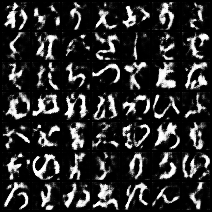

Epoch: 2  | 所要時間 0 分 31 秒
	Loss: 1.1483(Discriminator : True or False loss)
	Loss: 0.2880(Discriminator : classification loss)
	Loss: 0.2670(Discriminator : real_classification loss)
	Loss: 0.0211(Discriminator : fake_classification loss)
	Loss: -0.5679(Generator : True or False loss)
	Loss: -0.0179(Generator : classification loss)


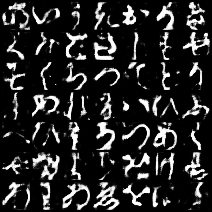

Epoch: 3  | 所要時間 0 分 31 秒
	Loss: 1.0747(Discriminator : True or False loss)
	Loss: 0.2284(Discriminator : classification loss)
	Loss: 0.2087(Discriminator : real_classification loss)
	Loss: 0.0198(Discriminator : fake_classification loss)
	Loss: -0.5536(Generator : True or False loss)
	Loss: -0.0165(Generator : classification loss)


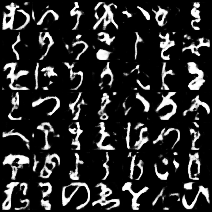

Epoch: 4  | 所要時間 0 分 31 秒
	Loss: 1.0240(Discriminator : True or False loss)
	Loss: 0.1950(Discriminator : classification loss)
	Loss: 0.1764(Discriminator : real_classification loss)
	Loss: 0.0186(Discriminator : fake_classification loss)
	Loss: -0.4775(Generator : True or False loss)
	Loss: -0.0152(Generator : classification loss)


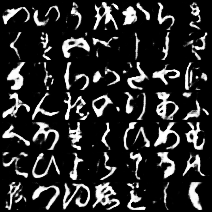

Epoch: 5  | 所要時間 0 分 31 秒
	Loss: 0.9689(Discriminator : True or False loss)
	Loss: 0.1835(Discriminator : classification loss)
	Loss: 0.1638(Discriminator : real_classification loss)
	Loss: 0.0197(Discriminator : fake_classification loss)
	Loss: -0.4473(Generator : True or False loss)
	Loss: -0.0154(Generator : classification loss)


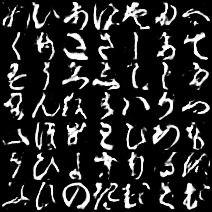

Epoch: 6  | 所要時間 0 分 31 秒
	Loss: 0.9613(Discriminator : True or False loss)
	Loss: 0.1700(Discriminator : classification loss)
	Loss: 0.1508(Discriminator : real_classification loss)
	Loss: 0.0192(Discriminator : fake_classification loss)
	Loss: -0.4285(Generator : True or False loss)
	Loss: -0.0147(Generator : classification loss)


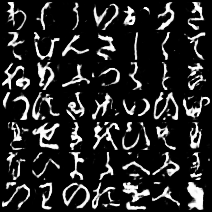

Epoch: 7  | 所要時間 0 分 31 秒
	Loss: 0.9266(Discriminator : True or False loss)
	Loss: 0.1562(Discriminator : classification loss)
	Loss: 0.1383(Discriminator : real_classification loss)
	Loss: 0.0179(Discriminator : fake_classification loss)
	Loss: -0.4205(Generator : True or False loss)
	Loss: -0.0138(Generator : classification loss)


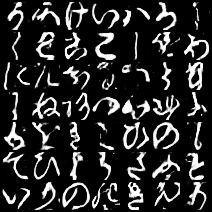

Epoch: 8  | 所要時間 0 分 31 秒
	Loss: 0.9483(Discriminator : True or False loss)
	Loss: 0.1476(Discriminator : classification loss)
	Loss: 0.1301(Discriminator : real_classification loss)
	Loss: 0.0175(Discriminator : fake_classification loss)
	Loss: -0.3843(Generator : True or False loss)
	Loss: -0.0132(Generator : classification loss)


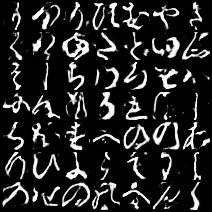

Epoch: 9  | 所要時間 0 分 31 秒
	Loss: 0.9389(Discriminator : True or False loss)
	Loss: 0.1341(Discriminator : classification loss)
	Loss: 0.1180(Discriminator : real_classification loss)
	Loss: 0.0162(Discriminator : fake_classification loss)
	Loss: -0.3894(Generator : True or False loss)
	Loss: -0.0125(Generator : classification loss)


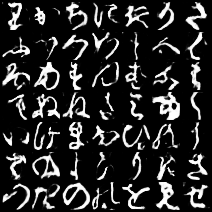

Epoch: 10  | 所要時間 0 分 31 秒
	Loss: 0.8916(Discriminator : True or False loss)
	Loss: 0.1359(Discriminator : classification loss)
	Loss: 0.1181(Discriminator : real_classification loss)
	Loss: 0.0178(Discriminator : fake_classification loss)
	Loss: -0.3793(Generator : True or False loss)
	Loss: -0.0135(Generator : classification loss)


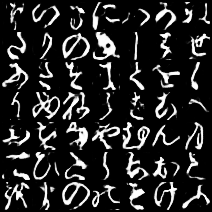

Epoch: 11  | 所要時間 0 分 31 秒
	Loss: 0.9001(Discriminator : True or False loss)
	Loss: 0.1248(Discriminator : classification loss)
	Loss: 0.1085(Discriminator : real_classification loss)
	Loss: 0.0162(Discriminator : fake_classification loss)
	Loss: -0.3598(Generator : True or False loss)
	Loss: -0.0121(Generator : classification loss)


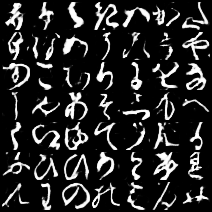

Epoch: 12  | 所要時間 0 分 31 秒
	Loss: 0.8694(Discriminator : True or False loss)
	Loss: 0.1190(Discriminator : classification loss)
	Loss: 0.1031(Discriminator : real_classification loss)
	Loss: 0.0159(Discriminator : fake_classification loss)
	Loss: -0.3630(Generator : True or False loss)
	Loss: -0.0118(Generator : classification loss)


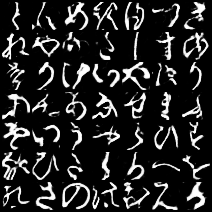

Epoch: 13  | 所要時間 0 分 31 秒
	Loss: 0.8888(Discriminator : True or False loss)
	Loss: 0.1129(Discriminator : classification loss)
	Loss: 0.0981(Discriminator : real_classification loss)
	Loss: 0.0148(Discriminator : fake_classification loss)
	Loss: -0.3220(Generator : True or False loss)
	Loss: -0.0113(Generator : classification loss)


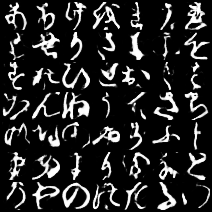

Epoch: 14  | 所要時間 0 分 31 秒
	Loss: 0.8722(Discriminator : True or False loss)
	Loss: 0.1074(Discriminator : classification loss)
	Loss: 0.0930(Discriminator : real_classification loss)
	Loss: 0.0144(Discriminator : fake_classification loss)
	Loss: -0.3340(Generator : True or False loss)
	Loss: -0.0106(Generator : classification loss)


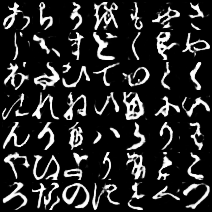

Epoch: 15  | 所要時間 0 分 31 秒
	Loss: 0.8353(Discriminator : True or False loss)
	Loss: 0.0993(Discriminator : classification loss)
	Loss: 0.0858(Discriminator : real_classification loss)
	Loss: 0.0135(Discriminator : fake_classification loss)
	Loss: -0.3166(Generator : True or False loss)
	Loss: -0.0101(Generator : classification loss)


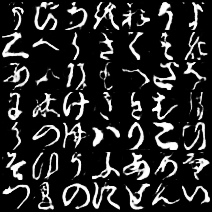

Epoch: 16  | 所要時間 0 分 31 秒
	Loss: 0.8501(Discriminator : True or False loss)
	Loss: 0.0977(Discriminator : classification loss)
	Loss: 0.0842(Discriminator : real_classification loss)
	Loss: 0.0135(Discriminator : fake_classification loss)
	Loss: -0.3188(Generator : True or False loss)
	Loss: -0.0099(Generator : classification loss)


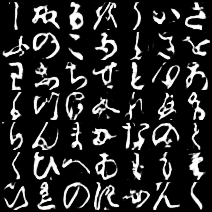

Epoch: 17  | 所要時間 0 分 31 秒
	Loss: 0.8273(Discriminator : True or False loss)
	Loss: 0.0913(Discriminator : classification loss)
	Loss: 0.0790(Discriminator : real_classification loss)
	Loss: 0.0123(Discriminator : fake_classification loss)
	Loss: -0.2957(Generator : True or False loss)
	Loss: -0.0092(Generator : classification loss)


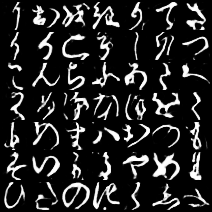

Epoch: 18  | 所要時間 0 分 31 秒
	Loss: 0.8185(Discriminator : True or False loss)
	Loss: 0.0891(Discriminator : classification loss)
	Loss: 0.0767(Discriminator : real_classification loss)
	Loss: 0.0123(Discriminator : fake_classification loss)
	Loss: -0.3000(Generator : True or False loss)
	Loss: -0.0092(Generator : classification loss)


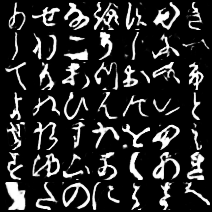

Epoch: 19  | 所要時間 0 分 31 秒
	Loss: 0.8375(Discriminator : True or False loss)
	Loss: 0.0864(Discriminator : classification loss)
	Loss: 0.0740(Discriminator : real_classification loss)
	Loss: 0.0123(Discriminator : fake_classification loss)
	Loss: -0.2827(Generator : True or False loss)
	Loss: -0.0091(Generator : classification loss)


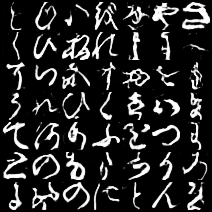

Epoch: 20  | 所要時間 0 分 31 秒
	Loss: 0.8193(Discriminator : True or False loss)
	Loss: 0.0858(Discriminator : classification loss)
	Loss: 0.0738(Discriminator : real_classification loss)
	Loss: 0.0121(Discriminator : fake_classification loss)
	Loss: -0.2920(Generator : True or False loss)
	Loss: -0.0095(Generator : classification loss)


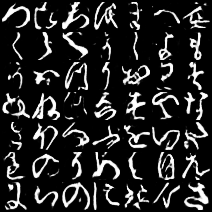

Epoch: 21  | 所要時間 0 分 31 秒
	Loss: 0.8059(Discriminator : True or False loss)
	Loss: 0.0819(Discriminator : classification loss)
	Loss: 0.0702(Discriminator : real_classification loss)
	Loss: 0.0118(Discriminator : fake_classification loss)
	Loss: -0.2932(Generator : True or False loss)
	Loss: -0.0089(Generator : classification loss)


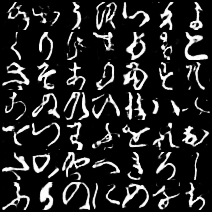

Epoch: 22  | 所要時間 0 分 31 秒
	Loss: 0.7670(Discriminator : True or False loss)
	Loss: 0.0819(Discriminator : classification loss)
	Loss: 0.0700(Discriminator : real_classification loss)
	Loss: 0.0119(Discriminator : fake_classification loss)
	Loss: -0.2834(Generator : True or False loss)
	Loss: -0.0088(Generator : classification loss)


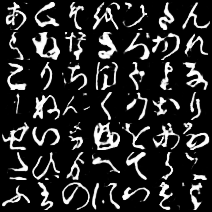

Epoch: 23  | 所要時間 0 分 31 秒
	Loss: 0.8374(Discriminator : True or False loss)
	Loss: 0.0776(Discriminator : classification loss)
	Loss: 0.0665(Discriminator : real_classification loss)
	Loss: 0.0110(Discriminator : fake_classification loss)
	Loss: -0.2766(Generator : True or False loss)
	Loss: -0.0084(Generator : classification loss)


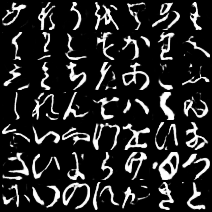

Epoch: 24  | 所要時間 0 分 31 秒
	Loss: 0.7937(Discriminator : True or False loss)
	Loss: 0.0689(Discriminator : classification loss)
	Loss: 0.0591(Discriminator : real_classification loss)
	Loss: 0.0098(Discriminator : fake_classification loss)
	Loss: -0.2712(Generator : True or False loss)
	Loss: -0.0073(Generator : classification loss)


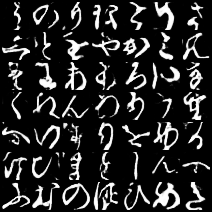

Epoch: 25  | 所要時間 0 分 31 秒
	Loss: 0.8216(Discriminator : True or False loss)
	Loss: 0.0680(Discriminator : classification loss)
	Loss: 0.0585(Discriminator : real_classification loss)
	Loss: 0.0095(Discriminator : fake_classification loss)
	Loss: -0.2690(Generator : True or False loss)
	Loss: -0.0074(Generator : classification loss)


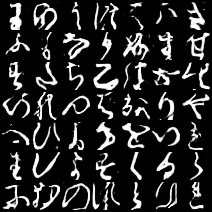

Epoch: 26  | 所要時間 0 分 31 秒
	Loss: 0.7955(Discriminator : True or False loss)
	Loss: 0.0659(Discriminator : classification loss)
	Loss: 0.0565(Discriminator : real_classification loss)
	Loss: 0.0094(Discriminator : fake_classification loss)
	Loss: -0.2665(Generator : True or False loss)
	Loss: -0.0070(Generator : classification loss)


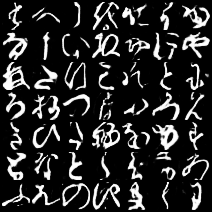

Epoch: 27  | 所要時間 0 分 31 秒
	Loss: 0.8067(Discriminator : True or False loss)
	Loss: 0.0634(Discriminator : classification loss)
	Loss: 0.0542(Discriminator : real_classification loss)
	Loss: 0.0093(Discriminator : fake_classification loss)
	Loss: -0.2578(Generator : True or False loss)
	Loss: -0.0069(Generator : classification loss)


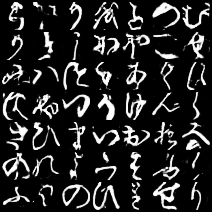

Epoch: 28  | 所要時間 0 分 31 秒
	Loss: 0.8007(Discriminator : True or False loss)
	Loss: 0.0658(Discriminator : classification loss)
	Loss: 0.0561(Discriminator : real_classification loss)
	Loss: 0.0097(Discriminator : fake_classification loss)
	Loss: -0.2498(Generator : True or False loss)
	Loss: -0.0073(Generator : classification loss)


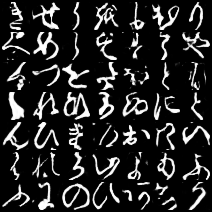

Epoch: 29  | 所要時間 0 分 31 秒
	Loss: 0.8153(Discriminator : True or False loss)
	Loss: 0.0646(Discriminator : classification loss)
	Loss: 0.0548(Discriminator : real_classification loss)
	Loss: 0.0099(Discriminator : fake_classification loss)
	Loss: -0.2648(Generator : True or False loss)
	Loss: -0.0076(Generator : classification loss)


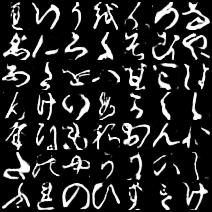

In [ ]:
D_TF_loss_list, G_TF_loss_list, D_class_loss_list, G_class_loss_list, real_class_loss_list, fake_class_loss_list, real, fake= model_run(num_epochs = 300)

## DiscriminatorとGeneratorのlossを表示

NameError: name 'D_TF_loss_list' is not defined

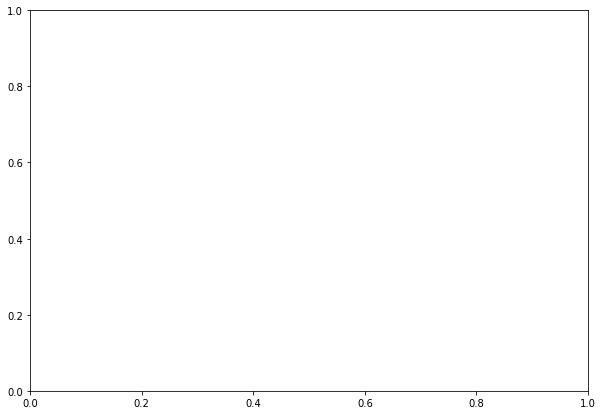

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,7))

loss = fig.add_subplot(1,1,1)

loss.plot(range(len(D_TF_loss_list)),D_TF_loss_list,label='Discriminator_T/F_loss',color='r')
loss.plot(range(len(G_TF_loss_list)),G_TF_loss_list,label='Generator_T/F_loss',color='b')
loss.plot(range(len(D_class_loss_list)),D_class_loss_list,label='Discriminator_class_loss',color='r', ls=':')
loss.plot(range(len(G_class_loss_list)),G_class_loss_list,label='Generator_class_loss',color='b',ls=':')

loss.set_xlabel('epoch')
loss.set_ylabel('loss')

loss.legend()
loss.grid()

fig.show()


## Discriminatorの本物クラスlossと偽物クラスlossを表示

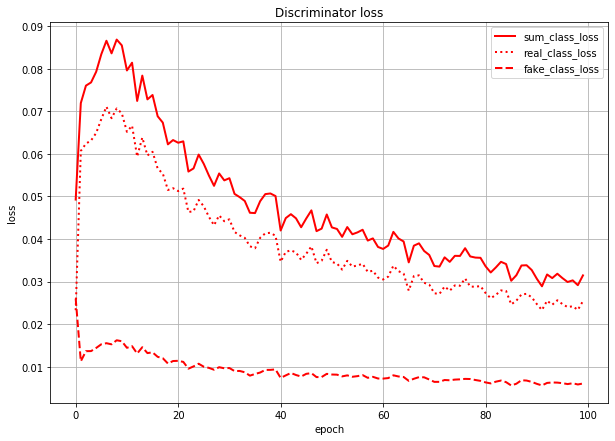

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,7))

loss = fig.add_subplot(1,1,1)

loss.plot(range(len(D_class_loss_list)),D_class_loss_list,label='sum_class_loss',color='r', linewidth='2.0')
loss.plot(range(len(real_class_loss_list)),real_class_loss_list,label='real_class_loss',color='r', ls=':', linewidth='2.0')
loss.plot(range(len(fake_class_loss_list)),fake_class_loss_list,label='fake_class_loss',color='r', ls='--', linewidth='2.0')

loss.set_xlabel('epoch')
loss.set_ylabel('loss')
loss.set_title('Discriminator loss')

loss.legend()
loss.grid()

fig.show()


## 上のグラフをiterごとにしてみる

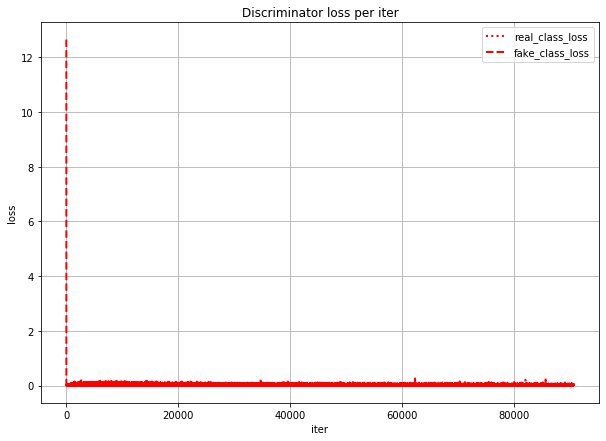

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,7))

loss = fig.add_subplot(1,1,1)

loss.plot(range(len(real)),real,label='real_class_loss',color='r', ls=':', linewidth='2.0')
loss.plot(range(len(fake)),fake,label='fake_class_loss',color='r', ls='--', linewidth='2.0')

loss.set_xlabel('iter')
loss.set_ylabel('loss')
loss.set_title('Discriminator loss per iter')

loss.legend()
loss.grid()

fig.show()

## アニメーションgifを作る

In [22]:
import glob
from PIL import Image

files = glob.glob('./logs_ACGAN/*.png')
files.sort()

new_files = []

images = list(map(lambda file: Image.open(file), files))

images[0].save('result_ACGAN.gif', save_all=True, append_images=images[1:100], duration=300, loop=0)

## 保存したcheckpointからモデルを取り出す

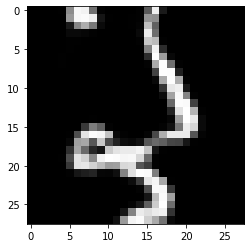

In [16]:
import os
import matplotlib.pyplot as plt
import cloudpickle
%matplotlib inline
#取り出すepochを指定する
point = 300

#モデルの構造を定義
z_dim = 100
num_class = 49
G = Generator(z_dim = z_dim, num_class = num_class)

#checkpointを取り出す
checkpoint = torch.load('./checkpoint_ACGAN/G_model_{}'.format(point))

#Generatorにパラメータを入れる
G.load_state_dict(checkpoint['model_state_dict'])

#検証モードにしておく
G.eval()

#生成したい文字のラベル
label = '1'

#取り出したモデルを使って狙った数字を生成
def return_img(Generator, label, img_dir, epoch):
    num_class = 49
    #ノイズ生成
    noise = torch.rand((1, z_dim))
    
    #Generatorに入れるラベルを生成
    z_label = torch.zeros(1, num_class)
    z_label[0,int(label)] = 1
    
    #Generatorでサンプル生成
    sample = Generator(noise, z_label)
    #save_image(sample, os.path.join(img_dir, 'epoch_%05d.png' % (epoch)))
    #img = Image(img_dir + 'epoch_%05d.png' % (epoch))
    
    return sample
    
dir_name = './'
sample = return_img(G, label, dir_name, point)
sample = sample.reshape((28,28))
sample = sample.detach().numpy().tolist()
plt.imshow(sample, cmap='gray')

#pickleで保存
with open ('KMNIST_ACGAN.pkl','wb')as f:
    cloudpickle.dump(G,f)

## 複数文字を入力して繋げた画像にする

In [24]:
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
%matplotlib inline

letter = 'あいうえおかきくけこさしすせそたちつてとなにぬねのはひふへほまみむめもやゆよらりるれろわゐゑをんゝ'

strs = input()
with open('KMNIST_ACGAN.pkl','rb')as f:
    G = cloudpickle.load(f)
    
for i in range(len(str(strs))):
    noise = torch.normal(mean = 0.5, std = 0.2, size = (1, 30))
    str_index = letter.index(strs[i])
    tmp = np.identity(49)[str_index]
    tmp = np.array(tmp, dtype = np.float32)
    label = [tmp]
    
    img = G(noise, torch.Tensor(label))
    img = img.reshape((1,28,28))
    np_img = img.reshape((28,28))
    np_img = np_img.detach().numpy().tolist()
    
    if i == 0:
        comp_img = img
        np_comp_img = np_img
    else:
        comp_img = torch.cat([comp_img,img],0)
        np_comp_img.extend(np_img)
comp_img = comp_img.reshape((len(strs)*28,28))
        
plt.imshow(np_comp_img, cmap='gray')
save_image(comp_img, './sample.png')
sample = Image('./sample.png')
display(sample)

 あいうえお


RuntimeError: size mismatch, m1: [1 x 30], m2: [100 x 300] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:136

## たくさんつくって比較してみる

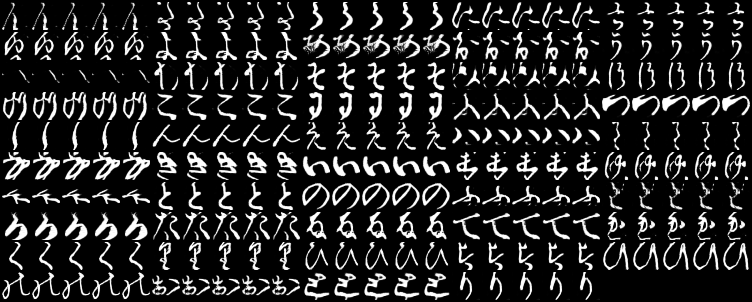

In [17]:
import cloudpickle
from IPython.display import Image

name = 'many_'

with open('KMNIST_ACGAN.pkl','rb')as f:
    G = cloudpickle.load(f)

#ノイズ生成
noise = torch.normal(mean = 0.5, std = 1, size = (num_class * 5, z_dim))

#Generatorに入れるラベル生成
labels = []
for i in range(num_class):
    tmp = np.identity(num_class)[i]
    tmp = np.array(tmp, dtype = np.float32)
    for k in range(5):
        labels.append(tmp)
label = torch.Tensor(labels)

samples = G(noise, label)
samples = (samples/2)+0.5
save_image(samples, './{}.png'.format(name), nrow = 25)
img = Image('./{}.png'.format(name))
display(img)